<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting_v2/blob/main/myStocks_Portfolio_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyxirr

In [2]:
# import libraries

import numpy as np
import pandas as pd
import datetime
import warnings
warnings.filterwarnings('ignore')
import yfinance as yfin
import matplotlib.pyplot as plt

In [3]:
# notebook start time
import time
import datetime
import pytz

start_time = time.time()

# function to print date timestamp
def print_date_time():
  tz_NY = pytz.timezone('Asia/Kolkata')
  datetime_NY = datetime.datetime.now(tz_NY)
  print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

In [4]:
# function to get booked and reserved amount
def get_amt():
  py_booked_amt = 304000 + 1007000
  cy_booked_amt = 377000 + 297000
  reserve_amt =  1000
  total_booked_amt = py_booked_amt + cy_booked_amt
  return total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt

total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt = get_amt()

gen_output = 0

In [5]:
# function to format the amount
def format_amt(number):
    abs_number = abs(number)

    if abs_number >= 1_00_00_000:  # Crores
        formatted_amt = f"{number / 1_00_00_000:.2f} C"
    elif abs_number >= 1_00_000:  # Lakhs
        formatted_amt = f"{number / 1_00_000:.2f} L"
    elif abs_number >= 1_000:  # Thousands
        formatted_amt = f"{number / 1_000:.2f} K"
    else:
        formatted_amt = f"{number:.2f}"

    return formatted_amt

# function to set start and end date
def get_start_end_date():
  start_date = (datetime.date.today() + datetime.timedelta(days=-365)).strftime('%Y-%m-%d')
  end_date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d')
  return start_date, end_date

# function to fetch my portfolio csv
def get_mypfs_df():
  mypfs_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myPortfolioStocks.csv')
  return mypfs_df

# function to fetch my prospects csv
def get_mypps_df():
  mypps_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myProspectsScrips.csv')
  return mypps_df

# function to fetch screener data
def get_myscreen_df():
  myscreen_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myScreenerDB.csv')
  return myscreen_df

# function to fetch momentum data
def get_myinvmt_df():
  myinvmt_df = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting_v1/main/data/myInvestments.csv')
  return myinvmt_df

# function to get the stock ids
def get_stock_ids(df_pf):
  stock_n100 = df_pf['Symbol'].unique()

  exclude = ['CADILAHC','MMTC', 'MASFIN']

  stock_ids = df_pf[~df_pf['Symbol'].isin(exclude) ]['Symbol'].unique()

  #mypf = mypf[mypf.Forecast.notnull()]
  #stock_ids = mypf['Symbol'].unique()

  stock_ids.sort()
  return stock_ids

# get features from screener data
def get_screener_features():
  myscreen_df = get_myscreen_df()
  cols = ['Symbol', 'EPS', 'MedPE', 'ROCE%', 'ROE%', 'CapType']
  return myscreen_df[cols]

# get relative strength
def get_relative_strength(stock_list):

    # Dictionary to store stock tickers and their corresponding percentage price change
    stock_changes = {}

    # Loop through each stock and fetch its price data
    for stock in stock_list:
        try:
            # Download the stock data for the given date range
            stock_data = yfin.Ticker(stock + '.NS').history(period='1mo', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]

            # Calculate the percentage change for the stock
            if len(stock_data) > 0:
                start_price = stock_data['Close'].iloc[0]
                end_price = stock_data['Close'].iloc[-1]
                percent_change = round(((end_price - start_price) / start_price) * 100, 2)
                stock_changes[stock] = percent_change
            else:
                stock_changes[stock] = np.nan  # If no data is available, set to NaN

        except Exception as e:
            print(f"Error fetching data for {stock}: {e}")
            stock_changes[stock] = np.nan

    # Create a DataFrame with stock tickers and their percentage changes
    df = pd.DataFrame(list(stock_changes.items()), columns=['Symbol', 'Percent_Change'])

    # Drop any stocks with missing data (NaN values)
    df = df.dropna()

    # Calculate the percentile rank based on percentage change
    df['RSP'] = round(df['Percent_Change'].rank(pct=True) * 100, 2)
    cols = ['Symbol', 'RSP']
    df = df[cols]
    # Sort by percentile rank (optional)
    df = df.sort_values(by='RSP', ascending=False).reset_index(drop=True)

    return df


In [6]:
# function to get stock technicals
def stock_prec_dev(stock_symbol):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = yfin.Ticker(stock_symbol + '.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]

    stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Symbol'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)
    stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df['Prev_Close'] = stock_df['Close'].shift(1)
    stock_df.drop(['Open', 'Low', 'High', 'Volume'], axis=1, inplace=True)
    stock_df = stock_df.tail(1)

    return stock_df

# function to compute stock attributes
def get_common_features(stock_ids, df_mypf):

  df_prec_dev = pd.DataFrame()
  df_tmp = get_screener_features()
  df_rs = get_relative_strength(stock_ids)

  for stock_id in stock_ids:
      tmp = stock_prec_dev(stock_id)
      tmp = tmp.reset_index()
      df_prec_dev = pd.concat([df_prec_dev, tmp], ignore_index = True)
  df_prec_dev = pd.merge(df_prec_dev, df_mypf, on= 'Symbol')
  df_prec_dev = pd.merge(df_prec_dev, df_tmp, on= 'Symbol', how='left')
  df_prec_dev = pd.merge(df_prec_dev, df_rs, on= 'Symbol', how='left')
  #print(df_prec_dev.columns)
  df_prec_dev['Curr_PE'] = round(df_prec_dev['Close']/df_prec_dev['EPS'],1)
  df_prec_dev['Dev%_PE'] = round((df_prec_dev['Curr_PE'] - df_prec_dev['MedPE'])*100/df_prec_dev['MedPE'],2)
  return df_prec_dev

# function to arrange stock features
def arrange_features(df_stocks, common_cols, diff_cols):
  df_stocks_common = df_stocks[common_cols].drop_duplicates()
  df_stocks_diff = df_stocks[diff_cols]
  df_stocks_diff['Investment'] = df_stocks_diff['AvgCost'] * df_stocks_diff['Shares']
  df_stocks_diff = df_stocks_diff.groupby(['Symbol'])[['Shares', 'Investment']].aggregate(['sum']).reset_index()
  df_stocks_diff.columns = ['Symbol', 'Shares', 'Investment']
  df_stocks_diff['AvgCost'] = round(df_stocks_diff['Investment']/df_stocks_diff['Shares'],2)
  df_stocks = pd.merge(df_stocks_diff, df_stocks_common, on='Symbol')
  return df_stocks

# plot fact distribution across dimension
def plot_pie_chart(df, dimension, fact):
  # grouping the data by category and calculating the sum of fact for each type
  grouped_data = df.groupby(dimension)[fact].sum()

  # sorting the grouped data in descending order
  grouped_data = grouped_data.sort_values(ascending=False)

  # creating a pie chart
  grouped_data.plot.pie(autopct='%1.1f%%', startangle=90, figsize=(6, 6))

  # adding a title and displaying the plot
  plt.title(f'{dimension} {fact} Distribution')
  plt.ylabel('')  # To hide the y-label
  plt.show()

In [7]:
# function to get portfolio features

def get_portfolio_features(df_common_features):

  print_date_time()
  print('-------------------')

  #df_common_features["Target"] = df_common_features["Target"].fillna(df_common_features["Max"])
  df_common_features['NTT'] = np.where(df_common_features['Strategy']== 'NTT', df_common_features["Target"], df_common_features['Max'])
  df_common_features['LTT'] = np.where(df_common_features['Strategy']== 'BTT', df_common_features["Target"], df_common_features['Max'])
  df_common_features['BOL'] = df_common_features['Min']

  tmp_df = df_common_features[df_common_features['Symbol'].isin(mypf_df[mypf_df['InPortfolio'] != 'NA'].Symbol.values)]
  print('qualified stocks: '+str(len(tmp_df['Symbol'].unique())))
  tmp_df1 = tmp_df[tmp_df['LatestQtr'] == 1]
  print('with latest results: '+str(len(tmp_df1['Symbol'].unique())))
  tmp_df1 = tmp_df1[tmp_df1['StarStock'] == 1]
  print('still star stocks: '+str(len(tmp_df1['Symbol'].unique())))
  tmp_df['Investment'] = tmp_df['AvgCost'] * tmp_df['Shares']
  tmp_df['Current'] = round(tmp_df['Close'] * tmp_df['Shares'],0)
  tmp_df['Previous'] = tmp_df['Prev_Close'] * tmp_df['Shares']
  tmp_df['EstimatedST'] = tmp_df['NTT'] * tmp_df['Shares']
  tmp_df['EstimatedLT'] = tmp_df['LTT'] * tmp_df['Shares']
  tmp_df['Current P/L'] = round((tmp_df['Current'] - tmp_df['Investment']),0)
  tmp_df['Today P/L%'] = round((tmp_df['Current'] - tmp_df['Previous'])*100/tmp_df['Previous'],2)
  tmp_df['Current P/L%'] = round((tmp_df['Current'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['EstimatedST P/L%'] = round((tmp_df['EstimatedST'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['EstimatedLT P/L%'] = round((tmp_df['EstimatedLT'] - tmp_df['Investment'])*100/tmp_df['Investment'],2)
  tmp_df['NTT%'] = round((tmp_df['NTT'] - tmp_df['Close'])*100/tmp_df['Close'],2)
  tmp_df['LTT%'] = round((tmp_df['LTT'] - tmp_df['Close'])*100/tmp_df['Close'],2)
  tmp_df['Gained%'] = round((tmp_df['Close'] - tmp_df['BOL'])*100/tmp_df['BOL'],2)
  investment = round(sum(tmp_df['AvgCost']*tmp_df['Shares']),0)
  current = round(sum(tmp_df['Close']*tmp_df['Shares']),0)
  tmp_df['InitAlloc%'] = round(tmp_df['Investment']*100/investment,2)
  tmp_df['CurrAlloc%'] = round(tmp_df['Current']*100/current,2)
  tmp_df['FTT'] = tmp_df['LTT']
  tmp_df.loc[tmp_df['Strategy'] == 'NTT', 'FTT'] = tmp_df['NTT']
  tmp_df['FTT%'] = tmp_df['LTT%']
  tmp_df.loc[tmp_df['Strategy'] == 'NTT', 'FTT%'] = tmp_df['NTT%']
  tmp_df['FTT Amt'] = round(tmp_df['FTT%'] * tmp_df['Current']/100,0)
  tmp_df['OTT%'] = round((tmp_df['FTT'] - tmp_df['AvgCost'])*100/tmp_df['AvgCost'],2)
  tmp_df['RRR Ind'] = round(tmp_df['Current P/L']/tmp_df['FTT Amt'],2)
  tmp_df['Risk Ind'] = round(tmp_df['Current P/L%']*tmp_df['CurrAlloc%'],0)

  return tmp_df

# function to print portfolio features
def print_portfolio_stats(df_portfolio_features, myinvmt_df):
  from pyxirr import xirr

  total_booked_amt, reserve_amt, cy_booked_amt, py_booked_amt = get_amt()

  dates = myinvmt_df['Date'].values
  dates = np.append(dates, datetime.date.today().strftime('%d-%b-%y'))
  investment = myinvmt_df['Investment'].values
  dates= pd.to_datetime(dates)

  current = round(sum(df_portfolio_features['Close']*df_portfolio_features['Shares']),0) + reserve_amt
  investment_xirr = np.append(investment, current)
  cagr = round(xirr(pd.DataFrame({"dates": dates, "amounts": investment_xirr}))*100,2)

  investment = -sum(investment)
  invested = round(sum(df_portfolio_features['AvgCost']*df_portfolio_features['Shares']),0) + reserve_amt
  previous = round(sum(df_portfolio_features['Prev_Close']*df_portfolio_features['Shares']),0) + reserve_amt
  cy_invested = investment + py_booked_amt

  today_pnl_amount = current-previous
  today_pnl_percentage = round((current-previous)*100/previous,2)

  curr_pnl_amount = current-invested
  curr_pnl_percentage = round((curr_pnl_amount)*100/(cy_invested),2)

  cy_pnl_amount = cy_booked_amt + curr_pnl_amount
  cy_pnl_percentage = round((cy_pnl_amount)*100/cy_invested,2)

  overall_pnl_amount = total_booked_amt + curr_pnl_amount
  overall_pnl_percentage = round((overall_pnl_amount)*100/investment,2)

  estimate_st = round(sum(df_portfolio_features['FTT']*df_portfolio_features['Shares']),0)  + reserve_amt
  est_st_pnl_amount = estimate_st-current
  est_st_pnl_percentage = round((est_st_pnl_amount)*100/current,2)

  estimate_lt = round(sum(df_portfolio_features['LTT']*df_portfolio_features['Shares']),0)  + reserve_amt
  est_lt_pnl_amount = estimate_lt-current
  est_lt_pnl_percentage = round((est_lt_pnl_amount)*100/current,2)

  total_profit = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] > 0]['Investment']),0)
  total_loss = round(sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Current']) - sum(df_portfolio_features[df_portfolio_features['Current P/L%'] < 0]['Investment']),0)

  cy_booked_percentage = round((cy_booked_amt)*100/current,2)
  py_booked_percentage = round((py_booked_amt)*100/investment,2)
  total_booked_percentage = round((total_booked_amt)*100/investment,2)

  print('-------------------')
  print('Initial Investment: ', format_amt(investment))
  print('CY Investment: ', format_amt(cy_invested))
  print('Reserve: ', format_amt(reserve_amt))
  print('Current: ',  format_amt(current))
  print('-------------------')
  print('Today PnL: '+ '{} ({}%)'.format(format_amt(today_pnl_amount), today_pnl_percentage))
  print('Current PnL: '+ '{} ({}%)'.format(format_amt(curr_pnl_amount), curr_pnl_percentage))
  print('CY Booked + Current PnL: '+ '{} ({}%)'.format(format_amt(cy_pnl_amount), cy_pnl_percentage))
  print('-------------------')
  print('Total profit: ', format_amt(total_profit))
  print('Total loss: ', format_amt(total_loss))
  print('-------------------')
  print('Total Booked + Current PnL: '+ '{} ({}%)'.format(format_amt(overall_pnl_amount), overall_pnl_percentage))
  print('Total Booked PnL: '+ '{} ({}%)'.format(format_amt(total_booked_amt), total_booked_percentage))
  print('Curr Year Booked PnL: '+ '{} ({}%)'.format(format_amt(cy_booked_amt), cy_booked_percentage))
  print('Prev Year Booked PnL: '+ '{} ({}%)'.format(format_amt(py_booked_amt), py_booked_percentage))
  print('===================')
  print('Est FTT: ',  format_amt(estimate_st))
  print('Est FTT PnL: '+ '{} ({}%)'.format(format_amt(est_st_pnl_amount), est_st_pnl_percentage))
  print('-------------------')
  print('Est LTT: ',  format_amt(estimate_lt))
  print('Est LTT PnL: '+ '{} ({}%)'.format(format_amt(est_lt_pnl_amount), est_lt_pnl_percentage))

  print('===================')
  print('Deployed: ', format_amt(investment))

  print('Current: ', format_amt(current))

  print('CAGR/XIRR %: '+'{}%'.format(cagr))

Run date time (IST): 2024-09-27 14:43:02
-------------------
qualified stocks: 86
with latest results: 82
still star stocks: 40
-------------------
Initial Investment:  95.12 L
CY Investment:  1.08 C
Reserve:  1.00 K
Current:  1.24 C
-------------------
Today PnL: 7.54 K (0.06%)
Current PnL: 9.16 L (8.47%)
CY Booked + Current PnL: 15.90 L (14.69%)
-------------------
Total profit:  13.61 L
Total loss:  -4.44 L
-------------------
Total Booked + Current PnL: 29.01 L (30.5%)
Total Booked PnL: 19.85 L (20.87%)
Curr Year Booked PnL: 6.74 L (5.42%)
Prev Year Booked PnL: 13.11 L (13.78%)
Est FTT:  1.82 C
Est FTT PnL: 58.00 L (46.6%)
-------------------
Est LTT:  2.30 C
Est LTT PnL: 1.05 C (84.58%)
Deployed:  95.12 L
Current:  1.24 C
CAGR/XIRR %: 29.47%


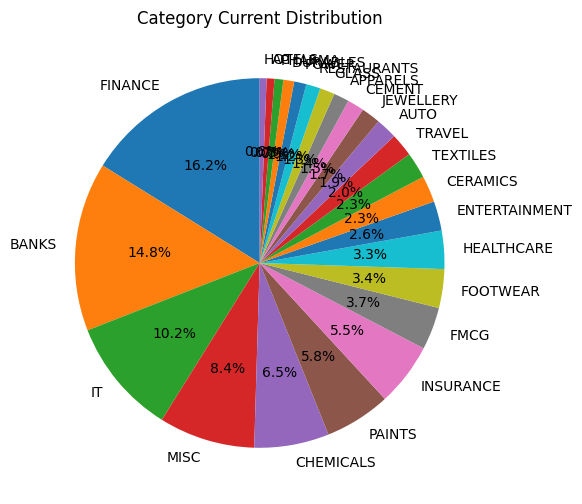

In [8]:
# get start and end date
start_date, end_date = get_start_end_date()

# get portfolio and prospects data
mypfs_df = get_mypfs_df()
mypps_df = get_mypps_df()
myinvmt_df = get_myinvmt_df()

# merge above datasets
mypf_df = pd.merge(mypfs_df, mypps_df, on="Symbol")

# seggregate dm and sv portfolio
dm_pf = mypf_df[mypf_df['InPortfolio'] == 'DM']
sv_pf = mypf_df[mypf_df['InPortfolio'] == 'SV']

# build portfolio stock dataframe
dm_stocks = get_stock_ids(dm_pf)
sv_stocks = get_stock_ids(sv_pf)
df_stocks = pd.concat([dm_pf,sv_pf], ignore_index = True)

# arrange common and diff stock features
common_cols = ['Symbol', 'Target', 'Criteria', 'Strategy', 'TFrame', 'LatestQtr', 'StarStock', 'BizFinTech', 'Conviction', 'Category', 'InFolio', 'XIRR', 'Remarks']
diff_cols = ['Symbol', 'AvgCost', 'Shares']
df_stocks = arrange_features(df_stocks, common_cols, diff_cols)

# get common features
stock_ids = df_stocks['Symbol'].values
df_common_features = get_common_features(stock_ids, df_stocks)

df_common_features.reset_index(drop=True, inplace=True)
df_common_features.drop(['Date'], axis=1, inplace=True)
# get and print portfolio features
df_portfolio_features = get_portfolio_features(df_common_features)

print_portfolio_stats(df_portfolio_features, myinvmt_df)

df = df_portfolio_features
plot_pie_chart(df, 'Category', 'Current')

In [9]:
# top 5 near their targets
cols = ['Symbol', 'AvgCost', 'Close', 'FTT', 'Dev%_PE', 'RSP', 'Current', 'Current P/L', 'FTT Amt', 'Today P/L%', 'Current P/L%', 'FTT%', 'OTT%', 'XIRR', 'RRR Ind', 'CurrAlloc%', 'Gained%', 'Criteria', 'Strategy', 'Category']
df_tmp = df_portfolio_features.sort_values(by = 'FTT Amt', ascending=True)
df_tmp[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
37,ICICIPRULI,508.03,788.10,835.0,59.64,77.91,156044.0,55454.0,9285.0,0.75,55.13,5.95,64.36,99.0,5.97,1.25,64.55,X40,BTT,INSURANCE
10,BAJAJFINSV,1473.47,1996.80,2116.0,-0.96,95.35,155750.0,40819.0,9298.0,0.71,35.52,5.97,43.61,24.0,4.39,1.25,35.25,X40,BTT,FINANCE
44,JIOFIN,320.24,360.30,387.0,3.61,91.86,177988.0,19789.0,13189.0,2.99,12.51,7.41,20.85,139.0,1.50,1.43,74.39,XSP,BTT,FINANCE
57,PIDILITIND,2482.94,3334.50,3576.0,2.55,87.21,193401.0,49390.0,14002.0,1.36,34.30,7.24,44.02,27.0,3.53,1.55,46.00,X40,BTT,CHEMICALS
33,HCLTECH,1349.00,1815.55,2006.0,44.44,79.07,136166.0,34991.0,14284.0,1.78,34.58,10.49,48.70,128.0,2.45,1.09,54.13,X40,BTT,IT


In [10]:
# top 5 for average up
tmp_df = df_portfolio_features[(df_portfolio_features['Current P/L%'] > 15) & (df_portfolio_features['FTT%'] > 15) ].sort_values(by = 'RSP', ascending=False)
tmp_df[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
45,JMFINANCIL,82.95,142.82,172.00,169.89,100.00,168099.0,70467.0,34343.0,1.12,72.18,20.43,107.35,96.0,2.05,1.35,103.71,XR,NTT,FINANCE
20,CAMPUS,294.86,349.50,631.85,34.33,98.84,198866.0,31091.0,160664.0,-2.28,18.53,80.79,114.29,187.0,0.19,1.60,62.94,XSP,ATH,FOOTWEAR
36,HINDUNILVR,2443.56,2989.75,3513.00,6.20,89.53,188354.0,34410.0,32962.0,0.12,22.35,17.50,43.77,34.0,1.04,1.51,37.59,X40,BTT,FMCG
52,LTIM,5051.49,6165.50,7286.80,24.92,84.88,98648.0,17824.0,17944.0,0.02,22.05,18.19,44.25,22.0,0.99,0.79,35.42,X200,ATH,IT
38,IEX,133.39,206.00,280.00,21.33,74.42,230514.0,81251.0,82801.0,-1.27,54.43,35.92,109.91,77.0,0.98,1.85,69.67,XR,NTT,MISC


In [11]:
# top 5 today
df_tmp = df_portfolio_features.sort_values(by = 'Today P/L%', ascending=False)
df_tmp[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
43,JCHAC,2143.67,2299.40,3542.00,NaN,97.67,85078.0,5762.0,45976.0,3.75,7.26,54.04,65.23,NaN,0.13,0.68,141.00,X40N,BTT,AC
5,ANGELONE,2246.65,2550.55,3791.17,-10.65,31.40,178538.0,21272.0,86841.0,3.03,13.53,48.64,68.75,106.0,0.24,1.43,39.93,X40N,ATH,FINANCE
44,JIOFIN,320.24,360.30,387.00,3.61,91.86,177988.0,19789.0,13189.0,2.99,12.51,7.41,20.85,139.0,1.50,1.43,74.39,XSP,BTT,FINANCE
17,BERGEPAINT,558.54,626.00,680.00,-17.43,82.56,198442.0,21385.0,17126.0,1.97,12.08,8.63,21.75,10.0,1.25,1.59,38.25,XSP,NTT,PAINTS
33,HCLTECH,1349.00,1815.55,2006.00,44.44,79.07,136166.0,34991.0,14284.0,1.78,34.58,10.49,48.70,128.0,2.45,1.09,54.13,X40,BTT,IT


In [12]:
# bottom 5 today
df_tmp = df_portfolio_features.sort_values(by = 'Today P/L%', ascending=True)
df_tmp[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
26,EASEMYTRIP,39.93,35.08,52.80,NaN,2.33,108327.0,-14977.0,54716.0,-4.10,-12.15,50.51,32.23,NaN,-0.27,0.87,2.21,XSP,NTT,TRAVEL
29,GLAND,1463.94,1780.90,2612.00,2.27,20.93,96169.0,17116.0,44882.0,-3.65,21.65,46.67,78.42,35.0,0.38,0.77,20.70,XR,NTT,PHARMA
20,CAMPUS,294.86,349.50,631.85,34.33,98.84,198866.0,31091.0,160664.0,-2.28,18.53,80.79,114.29,187.0,0.19,1.60,62.94,XSP,ATH,FOOTWEAR
54,MASFIN,326.60,294.10,470.00,-19.10,63.95,88230.0,-9750.0,52770.0,-2.08,-9.95,59.81,43.91,-83.0,-0.18,0.71,6.87,XR,BTT,FINANCE
65,SATIN,217.11,196.60,274.00,NaN,4.65,139783.0,-14582.0,55033.0,-1.87,-9.45,39.37,26.20,NaN,-0.26,1.12,6.53,XSP,NTT,FINANCE


In [13]:
# top 5 RSP
df_tmp = df_portfolio_features.sort_values(by = 'RSP', ascending=False)
df_tmp[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
45,JMFINANCIL,82.95,142.82,172.00,169.89,100.00,168099.0,70467.0,34343.0,1.12,72.18,20.43,107.35,96.0,2.05,1.35,103.71,XR,NTT,FINANCE
20,CAMPUS,294.86,349.50,631.85,34.33,98.84,198866.0,31091.0,160664.0,-2.28,18.53,80.79,114.29,187.0,0.19,1.60,62.94,XSP,ATH,FOOTWEAR
43,JCHAC,2143.67,2299.40,3542.00,NaN,97.67,85078.0,5762.0,45976.0,3.75,7.26,54.04,65.23,NaN,0.13,0.68,141.00,X40N,BTT,AC
84,VIPIND,488.80,555.90,718.00,NaN,96.51,108400.0,13084.0,31609.0,1.43,13.73,29.16,46.89,NaN,0.41,0.87,28.65,X40N,NTT,MISC
10,BAJAJFINSV,1473.47,1996.80,2116.00,-0.96,95.35,155750.0,40819.0,9298.0,0.71,35.52,5.97,43.61,24.0,4.39,1.25,35.25,X40,BTT,FINANCE


In [14]:
# top 5 of lower current allocation with minimal upside
df_tmp = df_portfolio_features[(df_portfolio_features['CurrAlloc%'] < 1) ].sort_values(by = 'FTT Amt', ascending=True)
df_tmp[cols].head()

,Symbol,AvgCost,Close,FTT,Dev%_PE,RSP,Current,Current P/L,FTT Amt,Today P/L%,Current P/L%,FTT%,OTT%,XIRR,RRR Ind,CurrAlloc%,Gained%,Criteria,Strategy,Category
50,LALPATHLAB,2519.90,3274.40,3689.0,1.16,29.07,117878.0,27162.0,14923.0,-0.21,29.94,12.66,46.39,51.0,1.82,0.95,63.47,X40N,NTT,HEALTHCARE
52,LTIM,5051.49,6165.50,7286.8,24.92,84.88,98648.0,17824.0,17944.0,0.02,22.05,18.19,44.25,22.0,0.99,0.79,35.42,X200,ATH,IT
24,DABUR,523.35,630.00,735.0,7.10,30.23,110250.0,18664.0,18379.0,0.68,20.38,16.67,40.44,31.0,1.02,0.89,27.77,X40,BTT,FMCG
40,INDUSINDBK,1354.50,1464.65,1800.0,-17.16,76.74,83485.0,6278.0,19118.0,0.82,8.13,22.90,32.89,8.0,0.33,0.67,9.46,XR,NTT,BANKS
81,UNIONBANK,124.65,124.98,163.0,-3.37,50.00,100484.0,265.0,30567.0,-1.56,0.26,30.42,30.77,NaN,0.01,0.81,35.39,XSP,NTT,BANKS


In [15]:
# notebook execution time

end_time = time.time()
execution_time = round(end_time - start_time, 0)
print(f"Notebook execution time: {execution_time} seconds")

Notebook execution time: 22.0 seconds
